# Mahti Fashion MNIST Experiment

In this notebook we go over the necessery manual actions for submitting a training job in Mahti using Allas integreated code. If you want to try to run this notebook yourself, you need already have the following:

- MyCSC account
- Project with billing units
- Access to Allas
- Access to Mahti
- SSH setup to Mahti

To begin, please create a python virtual enviroment, install the packages and open this notebook with the following:

```
python3 -m venv exp_venv
source exp_venv/bin/activate
pip install -r exp_req.txt
jupyter notebook
```
This notebook uses the following packages:
- notebook
- matplotlib
- torch
- torchvision
- torchmetrics
- python-decouple
- keystoneauth1
- python-swiftclient

## Data Analysis

In [9]:
import torch
from torchvision import datasets
import torchvision.transforms as T

image_labels = {
    0: 'Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

regular_transform = T.Compose([
    T.ToTensor()
])

source_train_data = datasets.FashionMNIST(
    root = './data', 
    train = True, 
    download = True, 
    transform = regular_transform
)

source_test_data = datasets.FashionMNIST(
    root = './data', 
    train = False, 
    download = True, 
    transform = regular_transform
)

In [2]:
import matplotlib.pyplot as plt

def first_columnsXrows_images(
    dataset: any,
    labels: any,
    columns: int,
    rows: int
):
    figure = plt.figure(figsize = (10,10))
    for i in range (1, columns * rows + 1):
        image, label = dataset[i]
        figure.add_subplot(
            rows, 
            columns, 
            i
        )
        plt.title(labels[label])
        plt.axis('off')
        plt.imshow(
            image.squeeze(), 
            cmap = 'gray'
        )
    plt.show()

def class_amounts(
    dataset: any,
    labels: any
):
    class_amounts = torch.bincount(dataset.targets)
    print('Class, amount:')
    for i in range(len(labels)):
        print(labels[i], class_amounts[i].item())

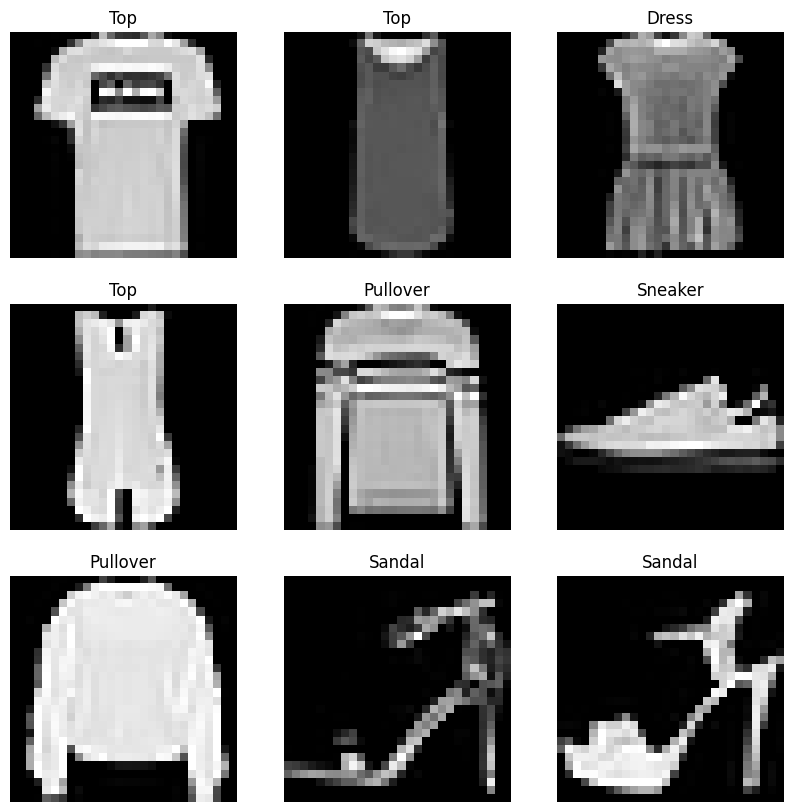

Train set has 60000 instances
Class, amount:
Top 6000
Trouser 6000
Pullover 6000
Dress 6000
Coat 6000
Sandal 6000
Shirt 6000
Sneaker 6000
Bag 6000
Ankle Boot 6000


In [3]:
first_columnsXrows_images(
    dataset = source_train_data,
    labels = image_labels,
    columns = 3,
    rows = 3
)
print('Train set has {} instances'.format(len(source_train_data)))
class_amounts(
    dataset = source_train_data,
    labels = image_labels
)

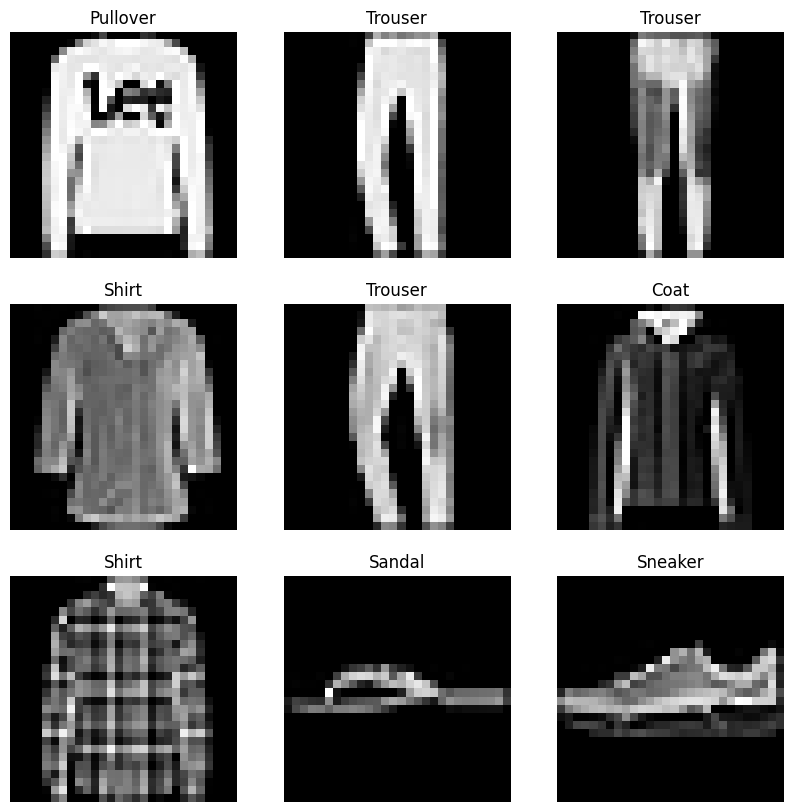

Test set has 10000 instances
Class, amount:
Top 1000
Trouser 1000
Pullover 1000
Dress 1000
Coat 1000
Sandal 1000
Shirt 1000
Sneaker 1000
Bag 1000
Ankle Boot 1000


In [4]:
first_columnsXrows_images(
    dataset = source_test_data,
    labels = image_labels,
    columns = 3,
    rows = 3
)
print('Test set has {} instances'.format(len(source_test_data)))
class_amounts(
    dataset = source_test_data,
    labels = image_labels
)

## Preprocessing

In [10]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST(
    root = './data', 
    train = True, 
    download = True, 
    transform = train_transform
)

test_data = datasets.FashionMNIST(
    root = './data', 
    train = False, 
    download = True, 
    transform = test_transform
)

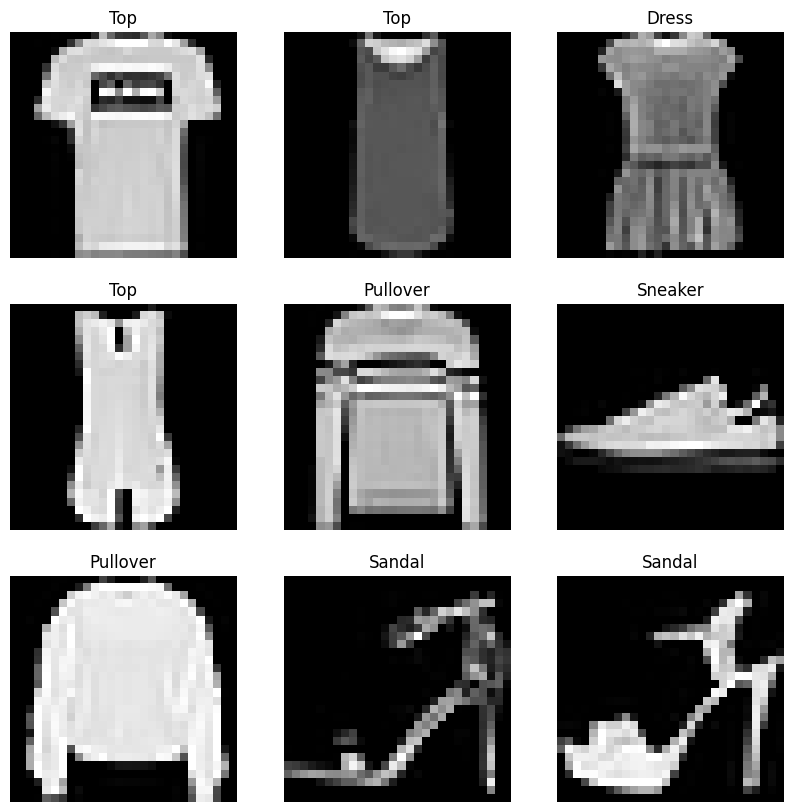

In [6]:
first_columnsXrows_images(
    dataset = train_data,
    labels = image_labels,
    columns = 3,
    rows = 3
)

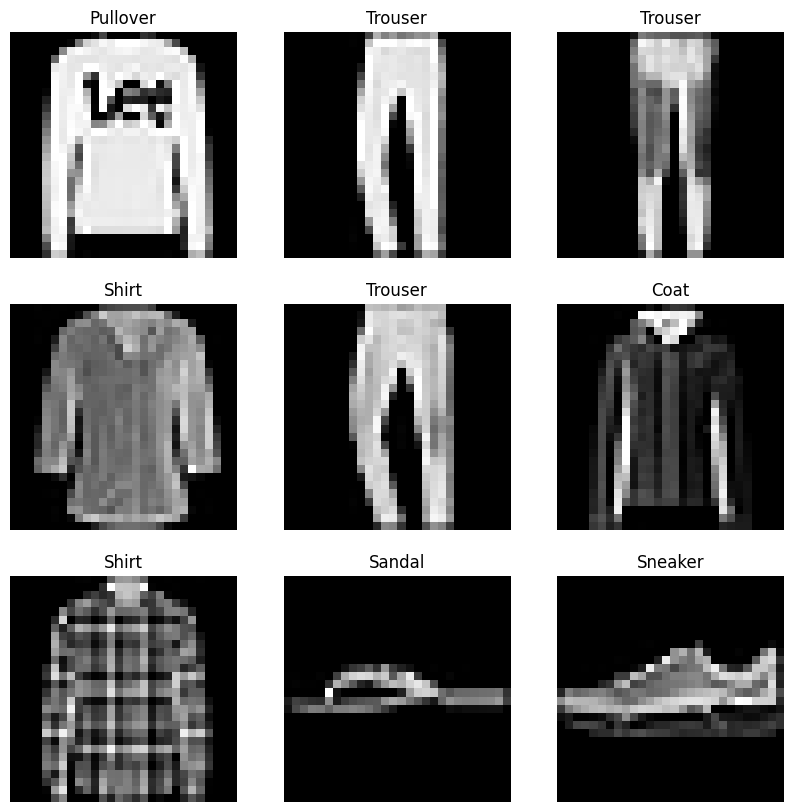

In [7]:
first_columnsXrows_images(
    dataset = test_data,
    labels = image_labels,
    columns = 3,
    rows = 3
)

In [11]:
train_batch_size = 4
test_batch_size = 4

train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size = train_batch_size, 
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size = test_batch_size, 
    shuffle = False
)

## Storing Preprocessd Data into Allas

In [12]:
from decouple import Config,RepositoryEnv

import pickle

from keystoneauth1 import loading, session
from keystoneauth1.identity import v3
from keystoneclient.v3 import client as keystone_client

import swiftclient as sc

import json

### Authentication

If you have not used Allas, please check the following CSC docs.

- [Python with swift](https://docs.csc.fi/data/Allas/using_allas/python_swift/)
- [Keystoneauth loader](https://docs.openstack.org/keystoneauth/latest/api/keystoneauth1.loading.html)
- [Keystoneauth session](https://docs.openstack.org/keystoneauth/latest/api/keystoneauth1.session.html)
- [Swiftclient](https://docs.openstack.org/python-swiftclient/stein/swiftclient.html)
- [CPouta APIs](https://docs.csc.fi/cloud/pouta/api-access/)

The short version is that you can get auth_url, auth_version, user, key, project name and user domain from the first document and the pre auth url from CPouta/Allas dashboard API access in object_store row. Use these docs to create a .env containing used credentials:

In [13]:
env_absolute_path = '()'

In [14]:
env_config = Config(RepositoryEnv(env_absolute_path))

_auth_url = 'https://pouta.csc.fi:5001/v3'
_pre_auth_url = 'https://a3s.fi:443/swift/v1/AUTH_6698ff90e6704a74930c33d6b66f1b5b'
_auth_version = '3'
_user = env_config.get('CSC_USERNAME')
_key = env_config.get('CSC_PASSWORD')
_project_name = env_config.get('CSC_PROJECT_NAME')
_user_domain_name = env_config.get('CSC_USER_DOMAIN_NAME')
_project_domain_name = env_config.get('CSC_USER_DOMAIN_NAME')

loader = loading.get_plugin_loader('password')
auth = loader.load_from_options(
    auth_url = _auth_url,
    username = _user,
    password = _key,
    project_name = _project_name,
    user_domain_name = _user_domain_name,
    project_domain_name = _project_domain_name
)

keystone_session = session.Session(
    auth = auth
)

given_token = keystone_session.get_token()

### Allas Client

In [15]:
def setup_allas(
    parameters: any
) -> any:
    allas_client = sc.Connection(
        preauthurl = parameters['pre_auth_url'],
        preauthtoken = parameters['pre_auth_token'],
        os_options = {
            'user_domain_name': parameters['user_domain_name'],
            'project_domain_name': parameters['project_domain_name'],
            'project_name': parameters['project_name']
        },
        auth_version = parameters['auth_version']
    )
    return allas_client

In [16]:
# Bucket names must be unique, so select another name
allas_bucket = '()'

parameters = {
    "pre_auth_url": str(_pre_auth_url),
    "pre_auth_token": str(given_token),
    "user_domain_name": str(_user_domain_name),
    "project_domain_name": str(_project_domain_name),
    "project_name": str(_project_name),
    'auth_version': str(_auth_version)
}

allas_client = setup_allas(
    parameters = parameters
)

### Allas Functions

In [17]:
def create_bucket(
    client: any,
    bucket_name: str
) -> bool:
    try:
        client.put_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def check_bucket(
    client: any,
    bucket_name:str
) -> bool:
    try:
        container_info = client.get_container(
            container = bucket_name
        )
        return container_info
    except Exception as e:
        return None 
    
def delete_bucket(
    client: any,
    bucket_name:str
) -> bool:
    try:
        client.delete_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def create_object(
    client: any,
    bucket_name: str, 
    object_path: str, 
    data: any
) -> bool: 
    try:
        client.put_object(
            container = bucket_name,
            obj = object_path + '.pkl',
            contents = pickle.dumps(data),
            content_type = 'application/pickle'
        )
        return True
    except Exception as e:
        return False
    
def check_object(
    client: any,
    bucket_name: str, 
    object_path: str
) -> any: 
    try:
        object_info = client.head_object(
            container = bucket_name,
            obj = object_path + '.pkl'
        )       
        return object_info
    except Exception as e:
        return {} 

def get_object(
    client:any,
    bucket_name: str,
    object_path: str
) -> any:
    try:
        content = client.get_object(
            container = bucket_name,
            obj = object_path + '.pkl' 
        )
        data = pickle.loads(content[1])
        return data
    except Exception as e:
        return None     
    
def remove_object(
    client: any,
    bucket_name: str, 
    object_path: str
) -> bool: 
    try:
        client.delete_object(
            container = bucket_name, 
            obj = object_path + '.pkl'
        )
        return True
    except Exception as e:
        return False

def update_object(
    client: any,
    bucket_name: str, 
    object_path: str, 
    data: any,
) -> bool:  
    remove = remove_object(
        client, 
        bucket_name, 
        object_path
    )
    if remove:
        create = create_object(
            client, 
            bucket_name, 
            object_path, 
            data
        )
        if create:
            return True
    return False

def check_or_create_object(
    client: any,
    bucket_name: str,
    object_path: str,
    data: any
) -> any:
    object_status = check_object(
        client,
        bucket_name,
        object_path
    )
    if object_status:
        return True
    return create_object(
        client, 
        bucket_name, 
        object_path, 
        data
    )

def create_or_update_object(
    client: any,
    bucket_name: str, 
    object_path: str, 
    data: any
) -> any:
    bucket_status = check_bucket(
        client, 
        bucket_name
    )
    
    if not bucket_status:
        creation_status = create_bucket(
            client, 
            bucket_name
        )
        if not creation_status:
            return False
    
    object_status = check_object(
        client, 
        bucket_name, 
        object_path
    )
    
    if not object_status:
        return create_object(
            client, 
            bucket_name, 
            object_path, 
            data
        )
    else:
        return update_object(
            client, 
            bucket_name, 
            object_path, 
            data
        )

def get_object_list(
    client: any,
    bucket_name: str,
    path_prefix: str
) -> dict:
    try:
        objects = client.get_container(container = bucket_name)[1]
        object_dict = {}
        for object in objects:
            metadata = {
                'hash': object['hash'],
                'bytes': object['bytes'],
                'last_modified': object['last_modified']
            }
            if path_prefix in object['name']:
                object_dict[object['name']] = metadata
        return object_dict
    except Exception as e:
        return None 

In [18]:
# Train loader
train_loader_status = create_or_update_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/DATA/train',
    data = train_loader
)
print(train_loader_status)

True


In [19]:
test_loader_status = create_or_update_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/DATA/test',
    data = test_loader
)
print(test_loader_status)

True


## Model Training

If you have not used Mahti, please check these docs:

- [Mahti quick guide](https://docs.csc.fi/support/tutorials/mahti_quick/)
- [Mahti connection](https://docs.csc.fi/computing/connecting/)
- [Mahti partitions](https://docs.csc.fi/computing/running/batch-job-partitions/)
- [Creating batch job](https://docs.csc.fi/computing/running/creating-job-scripts-puhti/)
- [Submitting Batch bobs](https://docs.csc.fi/computing/running/submitting-jobs/)
- [HPC Python](https://docs.csc.fi/apps/python/)
- [HPC PyTorch](https://docs.csc.fi/apps/pytorch/)

### Creating Training Script

Before you create the file, create a mahti_jobs folder.

In [23]:
%%writefile mahti_jobs/exp_train.py
import sys
import pickle
import json
import time as t

import swiftclient as sc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as TM

# Allas
def setup_allas(
    parameters: any
) -> any:
    allas_client = sc.Connection(
        preauthurl = parameters['pre_auth_url'],
        preauthtoken = parameters['pre_auth_token'],
        os_options = {
            'user_domain_name': parameters['user_domain_name'],
            'project_domain_name': parameters['project_domain_name'],
            'project_name': parameters['project_name']
        },
        auth_version = parameters['auth_version']
    )
    return allas_client

def create_bucket(
    client: any,
    bucket_name: str
) -> bool:
    try:
        client.put_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def check_bucket(
    client: any,
    bucket_name:str
) -> bool:
    try:
        container_info = client.get_container(
            container = bucket_name
        )
        return container_info
    except Exception as e:
        return None 
    
def delete_bucket(
    client: any,
    bucket_name:str
) -> bool:
    try:
        client.delete_container(
            container = bucket_name
        )
        return True
    except Exception as e:
        return False

def create_object(
    client: any,
    bucket_name: str, 
    object_path: str, 
    data: any
) -> bool: 
    try:
        client.put_object(
            container = bucket_name,
            obj = object_path + '.pkl',
            contents = pickle.dumps(data),
            content_type = 'application/pickle'
        )
        return True
    except Exception as e:
        return False
    
def check_object(
    client: any,
    bucket_name: str, 
    object_path: str
) -> any: 
    try:
        object_info = client.head_object(
            container = bucket_name,
            obj = object_path + '.pkl'
        )       
        return object_info
    except Exception as e:
        return {} 

def get_object(
    client:any,
    bucket_name: str,
    object_path: str
) -> any:
    try:
        content = client.get_object(
            container = bucket_name,
            obj = object_path + '.pkl' 
        )
        data = pickle.loads(content[1])
        return data
    except Exception as e:
        return None     
    
def remove_object(
    client: any,
    bucket_name: str, 
    object_path: str
) -> bool: 
    try:
        client.delete_object(
            container = bucket_name, 
            obj = object_path + '.pkl'
        )
        return True
    except Exception as e:
        return False

def update_object(
    client: any,
    bucket_name: str, 
    object_path: str, 
    data: any,
) -> bool:  
    remove = remove_object(
        client, 
        bucket_name, 
        object_path
    )
    if remove:
        create = create_object(
            client, 
            bucket_name, 
            object_path, 
            data
        )
        if create:
            return True
    return False

def check_or_create_object(
    client: any,
    bucket_name: str,
    object_path: str,
    data: any
) -> any:
    object_status = check_object(
        client,
        bucket_name,
        object_path
    )
    if object_status:
        return True
    return create_object(
        client, 
        bucket_name, 
        object_path, 
        data
    )

def create_or_update_object(
    client: any,
    bucket_name: str, 
    object_path: str, 
    data: any
) -> any:
    bucket_status = check_bucket(
        client, 
        bucket_name
    )
    
    if not bucket_status:
        creation_status = create_bucket(
            client, 
            bucket_name
        )
        if not creation_status:
            return False
    
    object_status = check_object(
        client, 
        bucket_name, 
        object_path
    )
    
    if not object_status:
        return create_object(
            client, 
            bucket_name, 
            object_path, 
            data
        )
    else:
        return update_object(
            client, 
            bucket_name, 
            object_path, 
            data
        )
# Pytorch
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_general_metrics():
    general_metrics = TM.MetricCollection([
        TM.classification.MulticlassAccuracy(
            num_classes = 10,
            average = 'macro'
        ),
        TM.classification.MulticlassPrecision(
            num_classes = 10,
            average = 'macro'
        ),
        TM.classification.MulticlassRecall(
            num_classes = 10,
            average = 'macro'
        )
    ])
    return general_metrics
    
def get_class_metrics():
    class_metrics = TM.MetricCollection([
        TM.classification.MulticlassAccuracy(
            num_classes = 10,
            average = None
        ),
        TM.classification.MulticlassPrecision(
            num_classes = 10,
            average = None
        ),
        TM.classification.MulticlassRecall(
            num_classes = 10,
            average = None
        )
    ])
    return class_metrics

def mahti_model_training(
    allas_client: any,
    allas_bucket: any,
    run_name: str,
    seed: int,
    train_print_rate: int,
    epochs: int,
    learning_rate: float,
    momentum: float,
    train_loader: any,
    test_loader: any
):
    time_start = t.time()

    print('Defining model')
    model = CNNClassifier()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr = learning_rate, 
        momentum = momentum
    )
    torch.manual_seed(seed)

    print('Defining metrics')
    general_metrics = get_general_metrics()
    class_metrics = get_class_metrics()
    
    print('Starting model training')
    current_epoch = 0
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = torch.max(outputs, 1)[1]
    
            general_metrics(preds, labels)
            
            if (i + 1) % train_print_rate == 0:
                avg_loss = running_loss / train_print_rate
                train_general_metrics = general_metrics.compute()
                acc = round(train_general_metrics['MulticlassAccuracy'].item(),3)
                pre = round(train_general_metrics['MulticlassPrecision'].item(),3)
                rec = round(train_general_metrics['MulticlassRecall'].item(),3)
                general_metrics.reset()
                print(f'Epoch: {epoch + 1}/{epochs}, Batch {i + 1}, Loss: {avg_loss}, Accuracy: {acc}, Precision: {pre}, Recall: {rec}')
                running_loss = 0.0
        current_epoch += 1
    print('Training complete')
    
    general_metrics.reset()
    
    print('Starting model testing')
    running_loss = 0.0
    predictions = []
    with torch.no_grad():
        model.eval()
        for i, data in enumerate(test_loader):
            inputs, labels = data
            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)
            general_metrics(preds, labels)
            class_metrics(preds, labels)
            predictions.extend(preds.tolist())
            running_loss += loss.item()
    print('Testing complete')

    print('Storing created artifacts')
    
    test_general_metrics = general_metrics.compute()
    test_class_metrics = class_metrics.compute()

    general_metrics.reset()
    class_metrics.reset()

    predictions_path = 'EXPERIMENT/ARTIFACTS/' + run_name + '-predictions'
    print('Predictions object path:' + str(predictions_path))
    predictions_status = create_or_update_object(
        client = allas_client,
        bucket_name = allas_bucket,
        object_path = predictions_path,
        data = predictions
    )
    print('Prediction storing status:' + str(predictions_status))
    
    print('Formatting model parameters')
    model_parameters = model.state_dict()
    optimizer_parameters = optimizer.state_dict()

    parameters = {
        'epoch': current_epoch,
        'model': model_parameters,
        'optimizer': optimizer_parameters
    }

    parameters_path = 'EXPERIMENT/ARTIFACTS/' + run_name + '-parameters'
    print('Predictions object path:' + str(parameters_path))
    parameters_status = create_or_update_object(
        client = allas_client,
        bucket_name = allas_bucket,
        object_path = parameters_path,
        data = parameters
    )
    print('Parameters storing status:' + str(parameters_status))

    print('Formatting model metrics')
    accuracy = test_general_metrics['MulticlassAccuracy'].item()
    precision = test_general_metrics['MulticlassPrecision'].item()
    recall = test_general_metrics['MulticlassRecall'].item()

    class_accuracy = test_class_metrics['MulticlassAccuracy'].tolist()
    class_precision = test_class_metrics['MulticlassPrecision'].tolist()
    class_recall = test_class_metrics['MulticlassRecall'].tolist()

    performance = {
        'name': 'Convolutional-neural-network-classifier',
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'class-accuracy': class_accuracy,
        'class-precision': class_precision,
        'class-recall': class_recall
    }

    print('Formatting used time')
    time_end = t.time()
    time_diff = (time_end - time_start) 
    
    time = {
        'name': 'mahti-model-training',
        'start-time': time_start,
        'end-time': time_end,
        'total-seconds': round(time_diff,5)
    }

    metrics = {
        'performance': performance,
        'time': time
    }

    metrics_path = 'EXPERIMENT/ARTIFACTS/' + run_name + '-metrics'
    print('Predictions object path:' + str(metrics_path))
    parameters_status = create_or_update_object(
        client = allas_client,
        bucket_name = allas_bucket,
        object_path = metrics_path,
        data = metrics
    )
    print('Metrics storing status:' + str(parameters_status))
    
if __name__ == "__main__":
    print('Starting batch job')
    print('Swiftclient version is:' + str(sc.__version__))
    print('Torch version is:' + str(torch.__version__))
    print('Torchmetrics version is:' + str(TM.__version__))

    print('Setting Allas client')
    parameters = json.loads(sys.argv[1])
    allas_client = setup_allas(
        parameters = parameters
    )
    allas_bucket = parameters['allas-bucket']
    run_name = parameters['run-name']
    print('Allas client setup')

    print('Getting data')
    train_loader = get_object(
        client = allas_client,
        bucket_name = allas_bucket,
        object_path = 'EXPERIMENT/DATA/train'
    )

    test_loader = get_object(
        client = allas_client,
        bucket_name = allas_bucket,
        object_path = 'EXPERIMENT/DATA/test'
    )
    print('Data loaded')

    print('Training')
    mahti_model_training(
        allas_client = allas_client,
        allas_bucket = allas_bucket,
        run_name = run_name,
        seed = 42,
        train_print_rate = 2000,
        epochs = 5,
        learning_rate = 0.001,
        momentum = 0.9,
        train_loader = train_loader,
        test_loader = train_loader
    )
    print('Training done')
    print('Batch job Complete')

Overwriting mahti_jobs/exp_train.py


### Passing Parameters

In order to get our username and password secure, we will use the provided time limited token by passing it using json dumping on the argument slot. Just copy the resulted print in between '' of the scripts.

In [ ]:
input_parameters = {
    "pre_auth_url": str(_pre_auth_url),
    "pre_auth_token": str(given_token),
    "user_domain_name": str(_user_domain_name),
    "project_domain_name": str(_project_domain_name),
    "project_name": str(_project_name),
    'auth_version': str(_auth_version),
    'allas-bucket': allas_bucket,
    'run-name': 'local'
}
dumped_parameters = json.dumps(input_parameters)
print(dumped_parameters)

### Local Testing

In [25]:
%run mahti_jobs/exp_train.py ''

Starting batch job
Swiftclient version is:4.5.0
Torch version is:2.3.0+cu121
Torchmetrics version is:1.4.0
Setting Allas client
Allas client setup
Getting data
Data loaded
Training
Defining model
Defining metrics
Starting model training
Epoch: 1/5, Batch 2000, Loss: 1.479656490302179, Accuracy: 0.468, Precision: 0.51, Recall: 0.468
Epoch: 1/5, Batch 4000, Loss: 0.7224705411517062, Accuracy: 0.721, Precision: 0.713, Recall: 0.721
Epoch: 1/5, Batch 6000, Loss: 0.6109513497052249, Accuracy: 0.765, Precision: 0.759, Recall: 0.765
Epoch: 1/5, Batch 8000, Loss: 0.5599310955705586, Accuracy: 0.787, Precision: 0.781, Recall: 0.787
Epoch: 1/5, Batch 10000, Loss: 0.5098107552874717, Accuracy: 0.812, Precision: 0.807, Recall: 0.812
Epoch: 1/5, Batch 12000, Loss: 0.4676041106015618, Accuracy: 0.827, Precision: 0.824, Recall: 0.827
Epoch: 1/5, Batch 14000, Loss: 0.4437285172127777, Accuracy: 0.833, Precision: 0.831, Recall: 0.833
Epoch: 2/5, Batch 2000, Loss: 0.40576349742061574, Accuracy: 0.847, P

Packages:
- Swiftclient version is:4.5.0
- Torch version is:2.3.0+cu121
- Torchmetrics version is:1.4.0

Hardware:
- Allas:
    - EXPERIMENT/DATA:
        - train = 45.32 MB
        - test = 7.56 MB
    - EXPERIMENT/ARTIFACTS:
        - local-metrics = 577 bytes
        - local-parameters = 353.44 KB
        - local-predictions = 117.33 KB  
- Personal computer:
    - Type = Laptop
    - CPU = Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz x 8 cores
    - RAM = 16 GB
    - DISK = 500 GB
    - OS = 64 bit Ubuntu 22.04.4 LTS

In [26]:
local_test_metrics = get_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/ARTIFACTS/local-metrics'
)

In [29]:
local_test_metrics

{'performance': {'name': 'Convolutional-neural-network-classifier',
  'accuracy': 0.9047666788101196,
  'precision': 0.9044160842895508,
  'recall': 0.9047666788101196,
  'class-accuracy': [0.8413333296775818,
   0.987666666507721,
   0.8798333406448364,
   0.8941666483879089,
   0.8463333249092102,
   0.9661666750907898,
   0.7088333368301392,
   0.9671666622161865,
   0.981166660785675,
   0.9750000238418579],
  'class-precision': [0.8509777188301086,
   0.9782106280326843,
   0.8360785841941833,
   0.9265975952148438,
   0.8336890339851379,
   0.9884058237075806,
   0.7430118918418884,
   0.9550691246986389,
   0.9748302698135376,
   0.9572901129722595],
  'class-recall': [0.8413333296775818,
   0.987666666507721,
   0.8798333406448364,
   0.8941666483879089,
   0.8463333249092102,
   0.9661666750907898,
   0.7088333368301392,
   0.9671666622161865,
   0.981166660785675,
   0.9750000238418579]},
 'time': {'name': 'mahti-model-training',
  'start-time': 1716542285.550912,
  'end-time

In [30]:
import json
with open('local_test_metrics.json', 'w') as f:
    json.dump(local_test_metrics, f, indent = 4)

In [31]:
local_test_parameters = get_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/ARTIFACTS/local-parameters'
)

In [33]:
torch.save(local_test_parameters['model'], 'local_test_model.pth')

In [34]:
torch.save(local_test_parameters['optimizer'], 'local_test_optimizer.pth')

In [35]:
local_predictions = get_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/ARTIFACTS/local-predictions'
)

In [36]:
import numpy as np
np.save('local_test_predictions.npy',local_predictions)

### Creating Batch job

In [21]:
%%writefile mahti_jobs/exp_job.sh
#!/bin/bash
#SBATCH --job-name=exp-job
#SBATCH --account=project_()
#SBATCH --partition=medium
#SBATCH --time=00:10:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=1
#SBATCH --mem=1GB

module load pytorch

echo "Loaded modules:"

module list

echo "Activating venv"

source /users/()/exp_venv/bin/activate

echo "Venv active"

echo "Installed packages"

pip list

echo "Packages listed"

echo "Running training script"

srun python3 exp_train.py ''

echo "Training script complete"

Overwriting scripts/exp_job.sh


### Passing Parameters

Copy the dumped parameters inside '' in exp_job.sh.

In [ ]:
input_parameters = {
    "pre_auth_url": str(_pre_auth_url),
    "pre_auth_token": str(given_token),
    "user_domain_name": str(_user_domain_name),
    "project_domain_name": str(_project_domain_name),
    "project_name": str(_project_name),
    'auth_version': str(_auth_version),
    'allas-bucket': allas_bucket,
    'run-name': 'mahti'
}
dumped_parameters = json.dumps(input_parameters)
print(dumped_parameters)

### Running Batch Job

We can make the job run in Mahti with the following commands:

```
ssh mahti

module load pytorch
python3 -m venv --system-site-packages exp_venv

nano exp_train.py  # In notebook CTRL + C and in nano CTRL + SHIFT + C
cat exp_train.py # Check that everything looks fine

nano exp_job.sh # In notebook CTRL + C and in nano CTRL + SHIFT + C
copy the dumped parameters inside ''
cat exp_job.sh # check that everything looks fine

sbatch exp_job.sh # Make job run
```

When you have submitted the job, check its status with:

```
# Please don't use these alongside seff in a smaller than 15 sec interval
squeue -u (user name)
sacct
```

The job will take around 5 minutes to complete, which you can check using provide commands. 

## Infrastructure

Packages:
- Swiftclient version is:4.4.0
- Torch version is:2.2.1+cu121
- Torchmetrics version is:1.3.1

Hardware:
- Allas (format is pickle):
    - EXPERIMENT/DATA:
        - train = 45.32 MB
        - test = 7.56 MB
    - EXPERIMENT/ARTIFACTS:
        - mahti-metrics = 577 bytes
        - mahti-parameters = 353.43 KB
        - mahti-predictions = 117.33KB

- Mahti:
    - Type = SLURM Cluster Node
    - Partition = Medium
    - Nodes = 1
    - CPU = AMD Zen 2 Rome 7H12 x 64 core
    - RAM = 1GB
    - OS = Linux

### Model Analysis

When the job is complete, you need to analyse the job and model artifacts. For job analysis its recommeded to create .txt files for generated artifacts or copy them into the notebook.

#### Job Artifacts 

#### Logs

To get logs, do the following:

```
cat slurm-(job-id).out
CTRL + SHIFT + C # Terminal
CTRL + V # Notebook
```

Example logs:

```
NOTE: This module uses Singularity. Some commands execute inside the container
(e.g. python3, pip3).

Loaded modules:

Currently Loaded Modules:
  1) gcc/11.2.0      3) openblas/0.3.18-omp       5) StdEnv
  2) openmpi/4.1.2   4) csc-tools           (S)   6) pytorch/2.2

  Where:
   S:  Module is Sticky, requires --force to unload or purge

 

Activating venv
Venv active
Installed packages
Package                   Version
------------------------- ------------------------
absl-py                   1.4.0
accelerate                0.27.2
addict                    2.4.0
affine                    2.4.0
aiohttp                   3.9.3
aiohttp-cors              0.7.0
aiorwlock                 1.4.0
aiosignal                 1.3.1
alembic                   1.13.1
annotated-types           0.6.0
anyio                     4.3.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
array-record              0.5.0
arrow                     1.3.0
assertpy                  1.1
asttokens                 2.4.1
async-lru                 2.0.4
async-timeout             4.0.3
attrs                     23.2.0
audioread                 3.0.1
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
blessed                   1.20.0
blinker                   1.7.0
blosc2                    2.5.1
cachetools                5.3.2
certifi                   2024.2.2
cffi                      1.16.0
cftime                    1.6.3
charset-normalizer        3.3.2
click                     8.1.7
click-plugins             1.1.1
cligj                     0.7.2
cloudpickle               3.0.0
cmake                     3.28.3
colorama                  0.4.6
colorful                  0.5.6
comm                      0.2.1
ConfigArgParse            1.7
contourpy                 1.2.0
cycler                    0.12.1
Cython                    3.0.8
dash                      2.15.0
dash-core-components      2.0.0
dash-html-components      2.0.0
dash-table                5.0.0
dask                      2024.2.1
dask-jobqueue             0.8.5
datasets                  2.17.1
debtcollector             3.0.0
debugpy                   1.8.1
decorator                 5.1.1
deepspeed                 0.13.3
deepspeed-kernels         0.0.1.dev1698255861
defusedxml                0.7.1
dill                      0.3.8
distlib                   0.3.8
distributed               2024.2.1
dm-tree                   0.1.8
docker                    7.0.0
entrypoints               0.4
et-xmlfile                1.1.0
etils                     1.5.2
evaluate                  0.4.1
exceptiongroup            1.2.0
executing                 2.0.1
faiss                     1.7.4
fastapi                   0.108.0
fastargs                  1.2.0
fastjsonschema            2.19.1
ffcv                      1.0.2
filelock                  3.13.1
fiona                     1.9.5
flask                     3.0.2
fonttools                 4.49.0
fqdn                      1.5.1
frozenlist                1.4.1
fsspec                    2023.10.0
fvcore                    0.1.5.post20221221
gensim                    4.3.2
geopandas                 0.14.3
gitdb                     4.0.11
GitPython                 3.1.42
google-api-core           2.17.1
google-auth               2.28.1
googleapis-common-protos  1.62.0
gpustat                   1.1.1
gpytorch                  1.11
graphviz                  0.20.1
greenlet                  3.0.3
grpcio                    1.62.0
gunicorn                  21.2.0
gym                       0.26.2
gym-notices               0.0.8
h11                       0.14.0
h5py                      3.10.0
hjson                     3.1.0
httpcore                  1.0.4
httptools                 0.6.1
httpx                     0.27.0
huggingface-hub           0.20.3
idna                      3.6
imageio                   2.34.0
imbalanced-learn          0.12.0
importlib-metadata        7.0.1
importlib-resources       6.1.2
iniconfig                 2.0.0
iopath                    0.1.10
ipykernel                 6.29.2
ipython                   8.18.1
ipython-genutils          0.2.0
ipywidgets                8.1.2
iso8601                   2.1.0
isoduration               20.11.0
itsdangerous              2.1.2
jaxtyping                 0.2.25
jedi                      0.19.1
Jinja2                    3.1.3
joblib                    1.3.2
json5                     0.9.17
jsonpatch                 1.33
jsonpointer               2.4
jsonschema                4.21.1
jsonschema-specifications 2023.12.1
jupyter-client            8.6.0
jupyter-core              5.7.1
jupyter-events            0.9.0
jupyter-lsp               2.2.2
jupyter-server            2.12.5
jupyter-server-mathjax    0.2.6
jupyter-server-terminals  0.5.2
jupyterlab                4.1.2
jupyterlab-git            0.50.0
jupyterlab-pygments       0.3.0
jupyterlab-server         2.25.3
jupyterlab-widgets        3.0.10
jupytext                  1.16.1
kagglehub                 0.1.9
keopscore                 2.2.2
keras                     3.0.5
keras-core                0.1.7
keras-cv                  0.8.2
keystoneauth1             5.6.0
kiwisolver                1.4.5
lazy-loader               0.3
librosa                   0.10.1
lightning                 2.2.0.post0
lightning-utilities       0.10.1
linear-operator           0.5.2
llvmlite                  0.42.0
lmdb                      1.4.1
locket                    1.0.0
lxml                      5.1.0
Mako                      1.3.2
Markdown                  3.5.2
markdown-it-py            3.0.0
MarkupSafe                2.1.5
matplotlib                3.8.3
matplotlib-inline         0.1.6
mdit-py-plugins           0.4.0
mdurl                     0.1.2
mistune                   3.0.2
ml-dtypes                 0.3.2
mlflow                    2.10.2
mpi4py                    3.1.5
mpmath                    1.3.0
msgpack                   1.0.7
multidict                 6.0.5
multiprocess              0.70.16
mysql-connector-python    8.3.0
namex                     0.0.7
nbclassic                 1.0.0
nbclient                  0.9.0
nbconvert                 7.16.1
nbdime                    4.0.1
nbformat                  5.9.2
ndindex                   1.8
nest-asyncio              1.6.0
netaddr                   1.2.1
netCDF4                   1.6.5
netifaces                 0.11.0
networkx                  3.2.1
ninja                     1.11.1.1
nltk                      3.8.1
notebook                  7.1.1
notebook-shim             0.2.4
numba                     0.59.0
numexpr                   2.9.0
numpy                     1.26.4
nvidia-cublas-cu12        12.1.3.1
nvidia-cuda-cupti-cu12    12.1.105
nvidia-cuda-nvrtc-cu12    12.1.105
nvidia-cuda-runtime-cu12  12.1.105
nvidia-cudnn-cu12         8.9.2.26
nvidia-cufft-cu12         11.0.2.54
nvidia-curand-cu12        10.3.2.106
nvidia-cusolver-cu12      11.4.5.107
nvidia-cusparse-cu12      12.1.0.106
nvidia-ml-py              12.535.133
nvidia-nccl-cu12          2.19.3
nvidia-nvjitlink-cu12     12.3.101
nvidia-nvtx-cu12          12.1.105
odfpy                     1.4.1
open3d                    0.18.0
opencensus                0.11.4
opencensus-context        0.1.3
opencv-python             4.9.0.80
openpyxl                  3.1.2
os-service-types          1.7.0
oslo.config               9.4.0
oslo.i18n                 6.3.0
oslo.serialization        5.4.0
oslo.utils                7.1.0
overrides                 7.7.0
packaging                 23.2
pandas                    2.2.1
pandocfilters             1.5.1
papermill                 2.5.0
parso                     0.8.3
partd                     1.4.1
pbr                       6.0.0
pexpect                   4.9.0
pillow                    10.2.0
pip                       20.2.4
platformdirs              4.2.0
plotly                    5.19.0
pluggy                    1.4.0
pooch                     1.8.1
portalocker               2.8.2
prometheus-client         0.20.0
promise                   2.3
prompt-toolkit            3.0.43
protobuf                  3.20.3
psutil                    5.9.8
ptyprocess                0.7.0
pure-eval                 0.2.2
py-cpuinfo                9.0.0
py-spy                    0.3.14
pyarrow                   15.0.0
pyarrow-hotfix            0.6
pyasn1                    0.5.1
pyasn1-modules            0.3.0
pybind11                  2.11.1
pycodestyle               2.11.1
pycparser                 2.21
pydantic                  2.6.2
pydantic-core             2.16.3
pydot                     2.0.0
pyflakes                  3.2.0
pyg-lib                   0.4.0
pyglet                    1.5.15
pygments                  2.17.2
pykeops                   2.2.2
pynndescent               0.5.11
pynvml                    11.5.0
pyparsing                 3.1.1
pyproj                    3.6.1
pyprojroot                0.3.0
pyquaternion              0.9.9
pysqlite3                 0.5.2
pytest                    7.4.4
python-dateutil           2.8.2
python-dotenv             1.0.1
python-json-logger        2.0.7
python-keystoneclient     5.3.0
python-swiftclient        4.4.0
pytorch-lightning         2.2.0.post0
pytorch-pfn-extras        0.7.6
pytorch3d                 0.7.6
pytz                      2023.4
PyYAML                    6.0.1
pyzmq                     25.1.2
querystring-parser        1.2.4
rasterio                  1.3.9
ray                       2.9.3
referencing               0.33.0
regex                     2023.12.25
requests                  2.31.0
responses                 0.18.0
retrying                  1.3.4
rfc3339-validator         0.1.4
rfc3986                   2.0.0
rfc3986-validator         0.1.1
rich                      13.7.0
rpds-py                   0.18.0
rsa                       4.9
safetensors               0.4.2
scikit-image              0.22.0
scikit-learn              1.4.1.post1
scipy                     1.12.0
seaborn                   0.13.2
Send2Trash                1.8.2
setuptools                50.3.2
shapely                   2.0.3
six                       1.16.0
smart-open                7.0.1
smmap                     5.0.1
sniffio                   1.3.1
snuggs                    1.4.7
sortedcontainers          2.4.0
soundfile                 0.12.1
soupsieve                 2.5
soxr                      0.3.7
SQLAlchemy                2.0.27
sqlparse                  0.4.4
stack-data                0.6.3
starlette                 0.32.0.post1
stevedore                 5.2.0
sympy                     1.12
tables                    3.9.2
tabulate                  0.9.0
tblib                     3.0.0
tenacity                  8.2.3
tensorboard               2.16.2
tensorboard-data-server   0.7.2
tensorboardX              2.6.2.2
tensorflow-datasets       4.9.3
tensorflow-metadata       1.14.0
termcolor                 2.4.0
terminado                 0.18.0
terminaltables            3.1.10
threadpoolctl             3.3.0
tifffile                  2024.2.12
timm                      0.9.16
tinycss2                  1.2.1
tokenizers                0.15.2
toml                      0.10.2
tomli                     2.0.1
toolz                     0.12.1
torch                     2.2.1+cu121
torch-cluster             1.6.3+pt22cu121
torch-geometric           2.5.0
torch-scatter             2.1.2+pt22cu121
torch-sparse              0.6.18+pt22cu121
torch-spline-conv         1.2.2+pt22cu121
torch-tb-profiler         0.4.3
torchaudio                2.2.1+cu121
torchdata                 0.7.1
torchmetrics              1.3.1
torchtext                 0.17.1
torchvision               0.17.1+cu121
tornado                   6.4
tqdm                      4.66.2
traitlets                 5.14.1
transformers              4.38.1
triton                    2.2.0
typeguard                 2.13.3
types-python-dateutil     2.8.19.20240106
typing-extensions         4.10.0
tzdata                    2024.1
umap-learn                0.5.5
uri-template              1.3.0
urllib3                   2.2.1
uvicorn                   0.27.1
uvloop                    0.19.0
virtualenv                20.25.1
visdom                    0.2.4
watchfiles                0.21.0
wcwidth                   0.2.13
webcolors                 1.13
webencodings              0.5.1
websocket-client          1.7.0
websockets                12.0
werkzeug                  3.0.1
wheel                     0.42.0
widgetsnbextension        4.0.10
wrapt                     1.16.0
xformers                  0.0.25+9469bb5.d20240226
xgboost                   2.0.3
xlwt                      1.3.0
xxhash                    3.4.1
yacs                      0.1.8
yarl                      1.9.4
zict                      3.0.0
zipp                      3.17.0
WARNING: You are using pip version 20.2.4; however, version 21.3.1 is available.
You should consider upgrading via the '/users/()/exp_venv/bin/python3 -m pip install --upgrade pip' command.
Packages listed
Running training script
Starting batch job
Swiftclient version is:4.4.0
Torch version is:2.2.1+cu121
Torchmetrics version is:1.3.1
Setting Allas client
Allas client setup
Getting data
Data loaded
Training
Defining model
Defining metrics
Starting model training
Epoch: 1/5, Batch 2000, Loss: 1.4155824606772511, Accuracy: 0.468, Precision: 0.532, Recall: 0.468
Epoch: 1/5, Batch 4000, Loss: 0.6662548610896338, Accuracy: 0.74, Precision: 0.73, Recall: 0.74
Epoch: 1/5, Batch 6000, Loss: 0.5833036828293698, Accuracy: 0.775, Precision: 0.766, Recall: 0.775
Epoch: 1/5, Batch 8000, Loss: 0.544558475752594, Accuracy: 0.798, Precision: 0.793, Recall: 0.798
Epoch: 1/5, Batch 10000, Loss: 0.4965742588493449, Accuracy: 0.816, Precision: 0.811, Recall: 0.816
Epoch: 1/5, Batch 12000, Loss: 0.4569825836728851, Accuracy: 0.835, Precision: 0.832, Recall: 0.835
Epoch: 1/5, Batch 14000, Loss: 0.4350309604742506, Accuracy: 0.839, Precision: 0.836, Recall: 0.839
Epoch: 2/5, Batch 2000, Loss: 0.392338078699162, Accuracy: 0.854, Precision: 0.851, Recall: 0.854
Epoch: 2/5, Batch 4000, Loss: 0.3812412682774302, Accuracy: 0.855, Precision: 0.854, Recall: 0.855
Epoch: 2/5, Batch 6000, Loss: 0.3749293539882346, Accuracy: 0.864, Precision: 0.862, Recall: 0.864
Epoch: 2/5, Batch 8000, Loss: 0.38837847040584894, Accuracy: 0.857, Precision: 0.854, Recall: 0.857
Epoch: 2/5, Batch 10000, Loss: 0.36818945913095374, Accuracy: 0.86, Precision: 0.858, Recall: 0.86
Epoch: 2/5, Batch 12000, Loss: 0.35124799989358874, Accuracy: 0.872, Precision: 0.871, Recall: 0.872
Epoch: 2/5, Batch 14000, Loss: 0.35977450371348824, Accuracy: 0.876, Precision: 0.875, Recall: 0.876
Epoch: 3/5, Batch 2000, Loss: 0.3312322363111234, Accuracy: 0.876, Precision: 0.875, Recall: 0.876
Epoch: 3/5, Batch 4000, Loss: 0.3175601156253997, Accuracy: 0.881, Precision: 0.881, Recall: 0.881
Epoch: 3/5, Batch 6000, Loss: 0.3180264241827899, Accuracy: 0.88, Precision: 0.879, Recall: 0.88
Epoch: 3/5, Batch 8000, Loss: 0.31147085925844115, Accuracy: 0.882, Precision: 0.882, Recall: 0.882
Epoch: 3/5, Batch 10000, Loss: 0.31510090760621823, Accuracy: 0.882, Precision: 0.882, Recall: 0.882
Epoch: 3/5, Batch 12000, Loss: 0.31997588389260273, Accuracy: 0.883, Precision: 0.883, Recall: 0.883
Epoch: 3/5, Batch 14000, Loss: 0.31961700767434376, Accuracy: 0.883, Precision: 0.883, Recall: 0.883
Epoch: 4/5, Batch 2000, Loss: 0.29511234444966933, Accuracy: 0.888, Precision: 0.887, Recall: 0.888
Epoch: 4/5, Batch 4000, Loss: 0.2894741716924145, Accuracy: 0.894, Precision: 0.894, Recall: 0.894
Epoch: 4/5, Batch 6000, Loss: 0.29670385265448024, Accuracy: 0.89, Precision: 0.89, Recall: 0.89
Epoch: 4/5, Batch 8000, Loss: 0.2919360376450177, Accuracy: 0.893, Precision: 0.892, Recall: 0.893
Epoch: 4/5, Batch 10000, Loss: 0.28578657424142145, Accuracy: 0.892, Precision: 0.892, Recall: 0.892
Epoch: 4/5, Batch 12000, Loss: 0.2850923455881839, Accuracy: 0.894, Precision: 0.893, Recall: 0.894
Epoch: 4/5, Batch 14000, Loss: 0.2885021425969135, Accuracy: 0.895, Precision: 0.895, Recall: 0.895
Epoch: 5/5, Batch 2000, Loss: 0.28429808658412364, Accuracy: 0.893, Precision: 0.893, Recall: 0.893
Epoch: 5/5, Batch 4000, Loss: 0.27398890914111595, Accuracy: 0.903, Precision: 0.903, Recall: 0.903
Epoch: 5/5, Batch 6000, Loss: 0.27901559940630066, Accuracy: 0.899, Precision: 0.898, Recall: 0.899
Epoch: 5/5, Batch 8000, Loss: 0.25830476998780477, Accuracy: 0.904, Precision: 0.904, Recall: 0.904
Epoch: 5/5, Batch 10000, Loss: 0.26413753225563597, Accuracy: 0.903, Precision: 0.902, Recall: 0.903
Epoch: 5/5, Batch 12000, Loss: 0.27688118035479237, Accuracy: 0.899, Precision: 0.899, Recall: 0.899
Epoch: 5/5, Batch 14000, Loss: 0.27374860078289204, Accuracy: 0.9, Precision: 0.899, Recall: 0.9
Training complete
Starting model testing
Testing complete
Storing created artifacts
Predictions object path:EXPERIMENT/ARTIFACTS/mahti-predictions
Prediction storing status:True
Formatting model parameters
Predictions object path:EXPERIMENT/ARTIFACTS/mahti-parameters
Parameters storing status:True
Formatting model metrics
Formatting used time
Predictions object path:EXPERIMENT/ARTIFACTS/mahti-metrics
Metrics storing status:True
Training done
Batch job Complete
Training script complete

```

#### Seff

To get seff, do this:

```
seff (job-id)
CTRL + SHIFT + C # Terminal
CTRL + V # Notebook
```

Example seff:

```
Job ID: 3459879
Cluster: mahti
User/Group: ()/pepr_()
State: COMPLETED (exit code 0)
Nodes: 1
Cores per node: 256
CPU Utilized: 00:04:56
CPU Efficiency: 0.37% of 21:58:24 core-walltime
Job Wall-clock time: 00:05:09
Memory Utilized: 374.88 MB
Memory Efficiency: 36.61% of 1.00 GB
Job consumed 8.58 CSC billing units based on following used resources
Billed project: project_()
Non-Interactive BUs: 8.58
```

#### Sacct

To get sacct, use the following function to get commands:

In [40]:
def format_sacct_command(
    category: str,
    job_id: str
):
    resource_fields = [
        'AveCPU',
        'AveCPUFreq',
        'AveDiskRead',
        'AveDiskWrite',
        'AvePages',
        'AveRSS',
        'AveVMSize',
        'ConsumedEnergyRaw'
    ]

    time_fields = [
        'Timelimit',
        'Submit',
        'Start',
        'Elapsed',
        'Planned',
        'End',
        'PlannedCPU',
        'CPUTime',
        'TotalCPU'
    ]

    used_fields = None
    if category == 'resource':
        used_fields = resource_fields
    if category == 'time':
        used_fields = time_fields
    
    sacct_command = 'sacct -o '
    i = 0 
    for field in used_fields:
        if len(used_fields) == i + 1:
            sacct_command += field
            break
        sacct_command += field + ','
        i += 1 

    sacct_command += ' -j ' + job_id
    return sacct_command

In [41]:
resource_sacct_command = format_sacct_command(
    category = 'resource',
    job_id = '3459879'
)
print(resource_sacct_command)

sacct -o AveCPU,AveCPUFreq,AveDiskRead,AveDiskWrite,AvePages,AveRSS,AveVMSize,ConsumedEnergyRaw -j 3459879


### Resource sacct

After running the given command, do this:

```
CTRL + SHIFT + C
CTRL + V
```

Example resource sacct:

```
    AveCPU AveCPUFreq    AveDiskRead   AveDiskWrite   AvePages     AveRSS  AveVMSize ConsumedEnergyRaw 
---------- ---------- -------------- -------------- ---------- ---------- ---------- ----------------- 
                                                                                                     0 
  00:00:01      2.60G          9.06M          0.08M         90      5684K     71964K                 0 
  00:00:00      2.60G          0.01M          0.00M          0          0          0                 0 
  00:04:54      1.85M         98.40M          0.06M       1886    383872K    878432K                 0
```

In [42]:
time_sacct_command = format_sacct_command(
    category = 'time',
    job_id = '3459879'
)
print(time_sacct_command)

sacct -o Timelimit,Submit,Start,Elapsed,Planned,End,PlannedCPU,CPUTime,TotalCPU -j 3459879


#### Time Sacct

After running the given command, do this:

```
CTRL + SHIFT + C
CTRL + V
```

Example time sacct:


```
 Timelimit              Submit               Start    Elapsed    Planned                 End PlannedCPU    CPUTime   TotalCPU 
---------- ------------------- ------------------- ---------- ---------- ------------------- ---------- ---------- ---------- 
  00:10:00 2024-05-24T13:06:53 2024-05-24T13:06:54   00:05:09   00:00:01 2024-05-24T13:12:03   00:00:01   21:58:24  04:55.666 
           2024-05-24T13:06:54 2024-05-24T13:06:54   00:05:09            2024-05-24T13:12:03              21:58:24  00:01.469 
           2024-05-24T13:06:54 2024-05-24T13:06:54   00:05:09            2024-05-24T13:12:03              21:58:24  00:00.001 
           2024-05-24T13:07:00 2024-05-24T13:07:00   00:05:03            2024-05-24T13:12:03              00:10:06  04:54.195 
```

## Training Artifacts

We can again get the artifacts by simply giving the wanted object path:

In [45]:
mahti_metrics = get_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/ARTIFACTS/mahti-metrics'
)

In [46]:
mahti_metrics

{'performance': {'name': 'Convolutional-neural-network-classifier',
  'accuracy': 0.9111332893371582,
  'precision': 0.9110545516014099,
  'recall': 0.9111332893371582,
  'class-accuracy': [0.8796666860580444,
   0.9865000247955322,
   0.8855000138282776,
   0.92166668176651,
   0.8263333439826965,
   0.9598333239555359,
   0.7294999957084656,
   0.9835000038146973,
   0.9793333411216736,
   0.9595000147819519],
  'class-precision': [0.8467832207679749,
   0.9842035174369812,
   0.8344589471817017,
   0.911638617515564,
   0.8679971694946289,
   0.9958499073982239,
   0.7793803215026855,
   0.9369640946388245,
   0.9814598560333252,
   0.9718095660209656],
  'class-recall': [0.8796666860580444,
   0.9865000247955322,
   0.8855000138282776,
   0.92166668176651,
   0.8263333439826965,
   0.9598333239555359,
   0.7294999957084656,
   0.9835000038146973,
   0.9793333411216736,
   0.9595000147819519]},
 'time': {'name': 'mahti-model-training',
  'start-time': 1716545233.4651463,
  'end-time

In [47]:
with open('mahti_metrics.json', 'w') as f:
    json.dump(mahti_metrics, f, indent = 4)

In [49]:
mahti_parameters = get_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/ARTIFACTS/mahti-parameters'
)

In [56]:
torch.save(mahti_parameters['model'], 'mahti_model.pth')

In [51]:
torch.save(mahti_parameters['optimizer'], 'mahti_optimizer.pth')

In [53]:
mahti_predictions = get_object(
    client = allas_client,
    bucket_name = allas_bucket,
    object_path = 'EXPERIMENT/ARTIFACTS/mahti-predictions'
)

In [54]:
import numpy as np
np.save('mahti_predictions.npy',mahti_predictions)

In [55]:
first_batch = next(iter(test_loader))
inputs, labels = first_batch
sample_inputs = inputs.numpy().tolist()
sample_labels = labels.numpy().tolist()

In [57]:
def inference(
    model_state_path: any,
    inputs: any
) -> any:
    model = CNNClassifier()
    model.load_state_dict(torch.load(model_state_path))
    predictions = []
    inputs = torch.tensor(np.array(inputs, dtype=np.float32))
    with torch.no_grad():
        model.eval()
        outputs = model(inputs)
        preds = torch.max(outputs, 1)[1]
        predictions.extend(preds.tolist())
    return predictions

In [58]:
created_preds = inference(
    model_state_path = 'mahti_model.pth',
    inputs = sample_inputs
)

In [59]:
created_preds

[9, 2, 1, 1]

In [60]:
sample_labels

[9, 2, 1, 1]